In [3]:
## Importing required libraries
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
from time import time

import warnings

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "inputs"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

database.sqlite



In [51]:
# Functions for generating the dataframe

def get_match_label(match):
    ''' Derives a label for a given match. '''
    
    #Define variables
    home_goals = match['home_team_goal']
    away_goals = match['away_team_goal']
     
    label = pd.DataFrame()
    label.loc[0,'match_api_id'] = match['match_api_id'] 

    #Identify match label  
    if home_goals > away_goals:
        label.loc[0,'label'] = "Win"
    if home_goals == away_goals:
        label.loc[0,'label'] = "Draw"
    if home_goals < away_goals:
        label.loc[0,'label'] = "Loss"

    #Return label        
    return label.loc[0]

def get_fifa_stats(match, player_stats):
    ''' Aggregates fifa stats for a given match. '''    
    
    #Define variables
    match_id =  match.match_api_id
    date = match['date']
    players = ['home_player_1', 'home_player_2', 'home_player_3', "home_player_4", "home_player_5",
               "home_player_6", "home_player_7", "home_player_8", "home_player_9", "home_player_10",
               "home_player_11", "away_player_1", "away_player_2", "away_player_3", "away_player_4",
               "away_player_5", "away_player_6", "away_player_7", "away_player_8", "away_player_9",
               "away_player_10", "away_player_11"]
    player_stats_new = pd.DataFrame()
    names = []
    
    #Loop through all players
    for player in players:   
            
        #Get player ID
        player_id = match[player]
        
        #Get player stats 
        stats = player_stats[player_stats.player_api_id == player_id]
            
        #Identify current stats       
        current_stats = stats[stats.date < date].sort_values(by = 'date', ascending = False)[:1]
        
        if np.isnan(player_id) == True:
            overall_rating = pd.Series(0)
        else:
            current_stats.reset_index(inplace = True, drop = True)
            overall_rating = pd.Series(current_stats.loc[0, "overall_rating"])

        #Rename stat
        name = "{}_overall_rating".format(player)
        names.append(name)
            
        #Aggregate stats
        player_stats_new = pd.concat([player_stats_new, overall_rating], axis = 1)
    
    player_stats_new.columns = names        
    player_stats_new['match_api_id'] = match_id

    player_stats_new.reset_index(inplace = True, drop = True)
    
    #Return player stats    
    return player_stats_new.loc[0] 

def get_fifa_data(matches, player_stats, path = None, data_exists = False):
    ''' Gets fifa data for all matches. '''  
    
    #Check if fifa data already exists
    if data_exists == True:
        
        fifa_data = pd.read_pickle(path)
        
    else:
        
        print("Collecting fifa data for each match...")       
        start = time()
        
        #Apply get_fifa_stats for each match
        fifa_data = matches.apply(lambda x :get_fifa_stats(x, player_stats), axis = 1)
        
        end = time()    
        print("Fifa data collected in {:.1f} minutes".format((end - start)/60))
    
    #Return fifa_data
    return fifa_data

def get_overall_fifa_rankings(fifa, get_overall = False):
    ''' Get overall fifa rankings from fifa data. '''
      
    temp_data = fifa
    
    #Check if only overall player stats are desired
    if get_overall == True:
        
        #Get overall stats
        data = temp_data.loc[:,(fifa.columns.str.contains('overall_rating'))]
        data.loc[:,'match_api_id'] = temp_data.loc[:,'match_api_id']
    else:
        
        #Get all stats except for stat date
        cols = fifa.loc[:,(fifa.columns.str.contains('date_stat'))]
        temp_data = fifa.drop(cols.columns, axis = 1)        
        data = temp_data
    
    #Return data
    return data

def get_last_matches(matches, date, team, x = 10):
    ''' Get the last x matches of a given team. '''
    
    #Filter team matches from matches
    team_matches = matches[(matches['home_team_api_id'] == team) | (matches['away_team_api_id'] == team)]
                           
    #Filter x last matches from team matches
    last_matches = team_matches[team_matches.date < date].sort_values(by = 'date', ascending = False).iloc[0:x,:]
    
    #Return last matches
    return last_matches

def get_last_matches_against_eachother(matches, date, home_team, away_team, x = 10):
    ''' Get the last x matches of two given teams. '''
    
    #Find matches of both teams
    home_matches = matches[(matches['home_team_api_id'] == home_team) & (matches['away_team_api_id'] == away_team)]    
    away_matches = matches[(matches['home_team_api_id'] == away_team) & (matches['away_team_api_id'] == home_team)]  
    total_matches = pd.concat([home_matches, away_matches])
    
    #Get last x matches
    try:    
        last_matches = total_matches[total_matches.date < date].sort_values(by = 'date', ascending = False).iloc[0:x,:]
    except:
        last_matches = total_matches[total_matches.date < date].sort_values(by = 'date', ascending = False).iloc[0:total_matches.shape[0],:]
        
        #Check for error in data
        if(last_matches.shape[0] > x):
            print("Error in obtaining matches")
            
    #Return data
    return last_matches

def get_goals(matches, team):
    ''' Get the goals of a specfic team from a set of matches. '''
    
    #Find home and away goals
    home_goals = int(matches.home_team_goal[matches.home_team_api_id == team].sum())
    away_goals = int(matches.away_team_goal[matches.away_team_api_id == team].sum())

    total_goals = home_goals + away_goals
    
    #Return total goals
    return total_goals

def get_goals_conceided(matches, team):
    ''' Get the goals conceided of a specfic team from a set of matches. '''

    #Find home and away goals
    home_goals = int(matches.home_team_goal[matches.away_team_api_id == team].sum())
    away_goals = int(matches.away_team_goal[matches.home_team_api_id == team].sum())

    total_goals = home_goals + away_goals

    #Return total goals
    return total_goals

def get_wins(matches, team):
    ''' Get the number of wins of a specfic team from a set of matches. '''
    
    #Find home and away wins
    home_wins = int(matches.home_team_goal[(matches.home_team_api_id == team) & (matches.home_team_goal > matches.away_team_goal)].count())
    away_wins = int(matches.away_team_goal[(matches.away_team_api_id == team) & (matches.away_team_goal > matches.home_team_goal)].count())

    total_wins = home_wins + away_wins

    #Return total wins
    return total_wins

def get_match_features(match, matches, x = 10):
    ''' Create match specific features for a given match. '''
    
    #Define variables
    date = match.date
    home_team = match.home_team_api_id
    away_team = match.away_team_api_id
    
    #Get last x matches of home and away team
    matches_home_team = get_last_matches(matches, date, home_team, x = 10)
    matches_away_team = get_last_matches(matches, date, away_team, x = 10)
    
    #Get last x matches of both teams against each other
    last_matches_against = get_last_matches_against_eachother(matches, date, home_team, away_team, x = 3)
    
    #Create goal variables
    home_goals = get_goals(matches_home_team, home_team)
    away_goals = get_goals(matches_away_team, away_team)
    home_goals_conceided = get_goals_conceided(matches_home_team, home_team)
    away_goals_conceided = get_goals_conceided(matches_away_team, away_team)
    
    #Define result data frame
    result = pd.DataFrame()
    
    #Define ID features
    result.loc[0, 'match_api_id'] = match.match_api_id
    result.loc[0, 'league_id'] = match.league_id

    #Create match features
    result.loc[0, 'home_team_goals_difference'] = home_goals - home_goals_conceided
    result.loc[0, 'away_team_goals_difference'] = away_goals - away_goals_conceided
    result.loc[0, 'games_won_home_team'] = get_wins(matches_home_team, home_team) 
    result.loc[0, 'games_won_away_team'] = get_wins(matches_away_team, away_team)
    result.loc[0, 'games_against_won'] = get_wins(last_matches_against, home_team)
    result.loc[0, 'games_against_lost'] = get_wins(last_matches_against, away_team)
    
    #Return match features
    return result.loc[0]

def get_match_label(match):
    ''' Derives a label for a given match. '''
    
    #Define variables
    home_goals = match['home_team_goal']
    away_goals = match['away_team_goal']
     
    label = pd.DataFrame()
    label.loc[0,'match_api_id'] = match['match_api_id'] 

    #Identify match label  
    if home_goals > away_goals:
        label.loc[0,'label'] = "Win"
    if home_goals == away_goals:
        label.loc[0,'label'] = "Draw"
    if home_goals < away_goals:
        label.loc[0,'label'] = "Loss"

    #Return label        
    return label.loc[0]

def create_features_and_labels(matches, fifa, bookkeepers, get_overall = False, horizontal = True, x = 10, verbose = True):
    ''' Create and aggregate features and labels for all matches. '''

    #Get fifa stats features
    fifa_stats = get_overall_fifa_rankings(fifa, get_overall)
    
    
    if verbose == True:
        print("Generating match features...")
    start = time()
    
    #Get match features for all matches
    match_stats = matches.apply(lambda x: get_match_features(x, matches, x = 10), axis = 1)
    
    # Remove League ID, we are only focusing in La Liga
    match_stats.drop(['league_id'], inplace = True, axis = 1)
    
    end = time()
    if verbose == True:
        print("Match features generated in {:.1f} minutes".format((end - start)/60))
    
    if verbose == True:    
        print("Generating match labels...")
    start = time()
    
    #Create match labels
    labels = matches.apply(get_match_label, axis = 1)
    end = time()
    if verbose == True:
        print("Match labels generated in {:.1f} minutes".format((end - start)/60))
    
    if verbose == True:    
        print("Generating bookkeeper data...")
    start = time()
    
    #Get bookkeeper quotas for all matches
    bk_data = get_bookkeeper_data(matches, bookkeepers, horizontal = True)
    bk_data.loc[:,'match_api_id'] = matches.loc[:,'match_api_id']
    end = time()
    if verbose == True:
        print("Bookkeeper data generated in {:.1f} minutes".format((end - start)/60))

    #Merges features and labels into one frame
    features = pd.merge(match_stats, fifa_stats, on = 'match_api_id', how = 'left')
    features = pd.merge(features, bk_data, on = 'match_api_id', how = 'left')
    feables = pd.merge(features, labels, on = 'match_api_id', how = 'left')
    
    #Drop NA values
    feables.dropna(inplace = True)
    
    #Return preprocessed data
    return feables

def train_classifier(clf, dm_reduction, X_train, y_train, cv_sets, params, scorer, jobs, use_grid_search = True, 
                     best_components = None, best_params = None):
    ''' Fits a classifier to the training data. '''
    
    #Start the clock, train the classifier, then stop the clock
    start = time()
    
    #Check if grid search should be applied
    if use_grid_search == True: 
        
        #Define pipeline of dm reduction and classifier
        estimators = [('dm_reduce', dm_reduction), ('clf', clf)]
        pipeline = Pipeline(estimators)
        
        #Grid search over pipeline and return best classifier
        grid_obj = model_selection.GridSearchCV(pipeline, param_grid = params, scoring = scorer, cv = cv_sets, n_jobs = jobs)
        grid_obj.fit(X_train, y_train)
        best_pipe = grid_obj.best_estimator_
    else:
        
        #Use best components that are known without grid search        
        estimators = [('dm_reduce', dm_reduction(n_components = best_components)), ('clf', clf(best_params))]
        pipeline = Pipeline(estimators)        
        best_pipe = pipeline.fit(X_train, y_train)
        
    end = time()
    
    #Print the results
    print("Trained {} in {:.1f} minutes".format(clf.__class__.__name__, (end - start)/60))
    
    #Return best pipe
    return best_pipe
    
def predict_labels(clf, best_pipe, features, target):
    ''' Makes predictions using a fit classifier based on scorer. '''
    
    #Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(best_pipe.named_steps['dm_reduce'].transform(features))
    end = time()
    
    #Print and return results
    print("Made predictions in {:.4f} seconds".format(end - start))
    return accuracy_score(target.values, y_pred)
    
def train_calibrate_predict(clf, dm_reduction, X_train, y_train, X_calibrate, y_calibrate, X_test, y_test, cv_sets, params, scorer, jobs, 
                            use_grid_search = True, **kwargs):
    ''' Train and predict using a classifer based on scorer. '''
    
    #Indicate the classifier and the training set size
    print("Training a {} with {}...".format(clf.__class__.__name__, dm_reduction.__class__.__name__))
    
    #Train the classifier
    best_pipe = train_classifier(clf, dm_reduction, X_train, y_train, cv_sets, params, scorer, jobs)
    
    #Calibrate classifier
    print("Calibrating probabilities of classifier...")
    start = time()    
    clf = CalibratedClassifierCV(best_pipe.named_steps['clf'], cv= 'prefit', method='isotonic')
    clf.fit(best_pipe.named_steps['dm_reduce'].transform(X_calibrate), y_calibrate)
    end = time()
    print("Calibrated {} in {:.1f} minutes".format(clf.__class__.__name__, (end - start)/60))
    
    # Print the results of prediction for both training and testing
    print("Score of {} for training set: {:.4f}.".format(clf.__class__.__name__, predict_labels(clf, best_pipe, X_train, y_train)))
    print("Score of {} for test set: {:.4f}.".format(clf.__class__.__name__, predict_labels(clf, best_pipe, X_test, y_test)))
    
    #Return classifier, dm reduction, and label predictions for train and test set
    return clf, best_pipe.named_steps['dm_reduce'], predict_labels(clf, best_pipe, X_train, y_train), predict_labels(clf, best_pipe, X_test, y_test)
        
def convert_odds_to_prob(match_odds):
    ''' Converts bookkeeper odds to probabilities. '''
    
    #Define variables
    match_id = match_odds.loc[:,'match_api_id']
    bookkeeper = match_odds.loc[:,'bookkeeper']    
    win_odd = match_odds.loc[:,'Win']
    draw_odd = match_odds.loc[:,'Draw']
    loss_odd = match_odds.loc[:,'Loss']
    
    #Converts odds to prob
    win_prob = 1 / win_odd
    draw_prob = 1 / draw_odd
    loss_prob = 1 / loss_odd
    
    total_prob = win_prob + draw_prob + loss_prob
    
    probs = pd.DataFrame()
    
    #Define output format and scale probs by sum over all probs
    probs.loc[:,'match_api_id'] = match_id
    probs.loc[:,'bookkeeper'] = bookkeeper
    probs.loc[:,'Win'] = win_prob / total_prob
    probs.loc[:,'Draw'] = draw_prob / total_prob
    probs.loc[:,'Loss'] = loss_prob / total_prob
    
    #Return probs and meta data
    return probs
    
def get_bookkeeper_data(matches, bookkeepers, horizontal = True):
    ''' Aggregates bookkeeper data for all matches and bookkeepers. '''
    
    bk_data = pd.DataFrame()
    
    #Loop through bookkeepers
    for bookkeeper in bookkeepers:

        #Find columns containing data of bookkeeper
        temp_data = matches.loc[:,(matches.columns.str.contains(bookkeeper))]
        temp_data.loc[:, 'bookkeeper'] = str(bookkeeper)
        temp_data.loc[:, 'match_api_id'] = matches.loc[:, 'match_api_id']
        
        #Rename odds columns and convert to numeric
        cols = temp_data.columns.values
        cols[:3] = ['Win','Draw','Loss']
        temp_data.columns = cols
        temp_data.loc[:,'Win'] = pd.to_numeric(temp_data['Win'])
        temp_data.loc[:,'Draw'] = pd.to_numeric(temp_data['Draw'])
        temp_data.loc[:,'Loss'] = pd.to_numeric(temp_data['Loss'])
        
        #Check if data should be aggregated horizontally
        if(horizontal == True):
            
            #Convert data to probs
            temp_data = convert_odds_to_prob(temp_data)
            temp_data.drop('match_api_id', axis = 1, inplace = True)
            temp_data.drop('bookkeeper', axis = 1, inplace = True)
            
            #Rename columns with bookkeeper names
            win_name = bookkeeper + "_" + "Win"
            draw_name = bookkeeper + "_" + "Draw"
            loss_name = bookkeeper + "_" + "Loss"
            temp_data.columns.values[:3] = [win_name, draw_name, loss_name]

            #Aggregate data
            bk_data = pd.concat([bk_data, temp_data], axis = 1)
        else:
            #Aggregate vertically
            bk_data = bk_data.append(temp_data, ignore_index = True)
    
    #If horizontal add match api id to data
    if(horizontal == True):
        temp_data.loc[:, 'match_api_id'] = matches.loc[:, 'match_api_id']
    
    #Return bookkeeper data
    return bk_data
    
def get_bookkeeper_probs(matches, bookkeepers, horizontal = False):
    ''' Get bookkeeper data and convert to probabilities for vertical aggregation. '''
    
    #Get bookkeeper data
    data = get_bookkeeper_data(matches, bookkeepers, horizontal = False)
    
    #Convert odds to probabilities
    probs = convert_odds_to_prob(data)
    
    #Return data
    return probs

def plot_confusion_matrix(y_test, X_test, clf, dim_reduce, path, cmap=plt.cm.Blues, normalize = False):    
    ''' Plot confusion matrix for given classifier and data. '''
    
    #Define label names and get confusion matrix values
    labels = ["Win", "Draw", "Loss"]
    cm = confusion_matrix(y_test, clf.predict(dim_reduce.transform(X_test)), labels)
    
    #Check if matrix should be normalized
    if normalize == True:
        
        #Normalize
        cm = cm.astype('float') / cm.sum()
        
    #Configure figure
    sns.set_style("whitegrid", {"axes.grid" : False})
    fig = plt.figure(1)    
    plt.imshow(cm, interpolation='nearest', cmap = plt.cm.Blues)
    title= "Confusion matrix of a {} with {}".format(best_clf.base_estimator.__class__.__name__, best_dm_reduce.__class__.__name__)   
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round(cm[i, j], 2),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    plt.show()
    
    #Print classification report
    y_pred = clf.predict(dim_reduce.transform(X_test))
    print(classification_report(y_test, y_pred)) 

def compare_probabilities(clf, dim_reduce, bk, bookkeepers, matches, fifa_data, verbose = False):
    ''' Map bookkeeper and model probabilities. '''
    
    #Create features and labels for given matches
    feables = create_feables(matches, fifa_data, bk, get_overall = True, verbose = False)
    
    #Ensure consistency
    match_ids = list(feables['match_api_id'])
    matches = matches[matches['match_api_id'].isin(match_ids)]
    
    #Get bookkeeper probabilities
    if verbose == True:
        print("Obtaining bookkeeper probabilities...")
    bookkeeper_probs = get_bookkeeper_probs(matches, bookkeepers)
    bookkeeper_probs.reset_index(inplace = True, drop = True)
    
    inputs = feables.drop('match_api_id', axis = 1)
    labels = inputs.loc[:,'label']
    features = inputs.drop('label', axis = 1)
    
    #Get model probabilities
    if verbose == True:
        print("Predicting probabilities based on model...")
    model_probs = pd.DataFrame()
    label_table = pd.Series()
    temp_probs = pd.DataFrame(clf.predict_proba(dim_reduce.transform(features)), columns = ['win_prob', 'draw_prob', 'loss_prob'])
    for bookkeeper in bookkeepers:
        model_probs = model_probs.append(temp_probs, ignore_index = True)
        label_table = label_table.append(labels)
    model_probs.reset_index(inplace = True, drop = True)
    label_table.reset_index(inplace = True, drop = True)
    bookkeeper_probs['win_prob'] = model_probs['win_prob']
    bookkeeper_probs['draw_prob'] = model_probs['draw_prob']
    bookkeeper_probs['loss_prob'] = model_probs['loss_prob']
    bookkeeper_probs['label'] = label_table 
    
    #Aggregate win probabilities for each match
    wins = bookkeeper_probs[['bookkeeper', 'match_api_id', 'Win', 'win_prob', 'label']]
    wins.loc[:, 'bet'] = 'Win'
    wins = wins.rename(columns = {'Win':'bookkeeper_prob',
                                  'win_prob': 'model_prob'})
                                  
    #Aggregate draw probabilities for each match
    draws = bookkeeper_probs[['bookkeeper', 'match_api_id', 'Draw', 'draw_prob', 'label']]
    draws.loc[:, 'bet'] = 'Draw'
    draws = draws.rename(columns = {'Draw':'bookkeeper_prob',
                                  'draw_prob': 'model_prob'})
                                  
    #Aggregate loss probabilities for each match
    losses = bookkeeper_probs[['bookkeeper', 'match_api_id', 'Loss', 'loss_prob', 'label']]
    losses.loc[:, 'bet'] = 'Loss'
    losses = losses.rename(columns = {'Loss':'bookkeeper_prob',
                                  'loss_prob': 'model_prob'})
    
    total = pd.concat([wins, draws, losses])
    
    #Return total
    return total
    
def find_good_bets(clf, dim_reduce, bk, bookkeepers, matches, fifa_data, percentile, prob_cap, verbose = False):
    ''' Find good bets for a given classifier and matches. '''
    
    #Compare model and classifier probabilities
    probs = compare_probabilities(clf, dim_reduce, bk, bookkeepers, matches, fifa_data, verbose = False)
    probs.loc[:, 'prob_difference'] = probs.loc[:,"model_prob"] - probs.loc[:,"bookkeeper_prob"]
    
    #Sort by createst difference to identify most underestimated bets    
    values = probs['prob_difference']
    values = values.sort_values(ascending = False)
    values.reset_index(inplace = True, drop = True)
    
    if verbose == True:
        print("Selecting attractive bets...")
        
    #Identify choices that fulfill requirements such as positive difference, minimum probability and match outcome
    relevant_choices = probs[(probs.prob_difference > 0) & (probs.model_prob > prob_cap) & (probs.bet != "Draw")]
    
    #Select given percentile of relevant choices    
    top_percent = 1 - percentile
    choices = relevant_choices[relevant_choices.prob_difference >= relevant_choices.prob_difference.quantile(top_percent)]
    choices.reset_index(inplace = True, drop = True)
    
    return choices

def explore_data(features, inputs, path):
    ''' Explore data by plotting KDE graphs. '''
    
    #Define figure subplots
    fig = plt.figure(1)
    fig.subplots_adjust(bottom= -1, left=0.025, top = 2, right=0.975)
    
    #Loop through features    
    i = 1
    for col in features.columns:
        
        #Set subplot and plot format        
        sns.set_style("whitegrid")
        sns.set_context("paper", font_scale = 0.5, rc={"lines.linewidth": 1})
        plt.subplot(7,7,0 + i)
        j = i - 1
        
        #Plot KDE for all labels
        sns.distplot(inputs[inputs['label'] == 'Win'].iloc[:,j], hist = False, label = 'Win')
        sns.distplot(inputs[inputs['label'] == 'Draw'].iloc[:,j], hist = False, label = 'Draw')
        sns.distplot(inputs[inputs['label'] == 'Loss'].iloc[:,j], hist = False, label = 'Loss')
        plt.legend();
        i = i + 1
    
    #Define plot format    
    DefaultSize = fig.get_size_inches()
    fig.set_size_inches((DefaultSize[0]*1.2, DefaultSize[1]*1.2))

    plt.show()
    
    #Compute and print label weights
    labels = inputs.loc[:,'label']
    class_weights = labels.value_counts() / len(labels)
    print(class_weights)
    
    #Store description of all features
    feature_details = features.describe().transpose()

    #Return feature details
    return feature_details

In [49]:
start = time()
## Fetching data
#Connecting to database
path = "inputs/"  #Insert path here
database = path + 'database.sqlite'
conn = sqlite3.connect(database)

#Defining the number of jobs to be run in parallel during grid search
n_jobs = 1 #Insert number of parallel jobs here

#Fetching required data tables
player_data = pd.read_sql("SELECT * FROM Player;", conn)
player_stats_data = pd.read_sql("SELECT * FROM Player_Attributes;", conn)
team_data = pd.read_sql("SELECT * FROM Team;", conn)
match_data = pd.read_sql("SELECT * FROM Match WHERE league_id = 21518;", conn)

# Remove rows where any of these columns is NaN
rows = ["country_id", "league_id", "season", "stage", "date", "match_api_id", "home_team_api_id", 
        "away_team_api_id", "home_team_goal", "away_team_goal", "home_player_1", "home_player_2",
        "home_player_3", "home_player_4", "home_player_5", "home_player_6", "home_player_7", 
        "home_player_8", "home_player_9", "home_player_10", "home_player_11", "away_player_1",
        "away_player_2", "away_player_3", "away_player_4", "away_player_5", "away_player_6",
        "away_player_7", "away_player_8", "away_player_9", "away_player_10", "away_player_11"]
match_data.dropna(subset = rows, inplace = True)
match_data.head(5)

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,21518,21518,21518,2008/2009,1,2008-08-30 00:00:00,530023,10267,8661,3,...,5.0,1.65,3.40,4.50,1.75,3.30,5.00,1.67,3.40,5.00
1,21519,21518,21518,2008/2009,1,2008-08-31 00:00:00,530084,8371,10205,1,...,2.6,2.90,3.20,2.25,2.75,3.20,2.50,2.80,3.25,2.30
2,21520,21518,21518,2008/2009,1,2008-08-31 00:00:00,530085,9783,8633,2,...,1.9,3.25,3.25,2.00,3.50,3.20,2.10,3.25,3.25,2.10
4,21522,21518,21518,2008/2009,1,2008-08-31 00:00:00,530087,8696,8302,1,...,2.3,2.70,3.10,2.40,2.75,3.25,2.45,2.70,3.25,2.38
6,21524,21518,21518,2008/2009,1,2008-08-31 00:00:00,530089,8603,8479,0,...,4.5,1.75,3.25,4.35,1.95,3.20,4.00,1.73,3.30,4.50


Fifa data collected in 4.5 minutes
Generating match features...
Match features generated in 1.6 minutes
Generating match labels...
Match labels generated in 0.2 minutes
Generating bookkeeper data...


/Users/paulsmsm/miniconda2/envs/ipykernel_py3/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/paulsmsm/miniconda2/envs/ipykernel_py3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


Bookkeeper data generated in 0.0 minutes


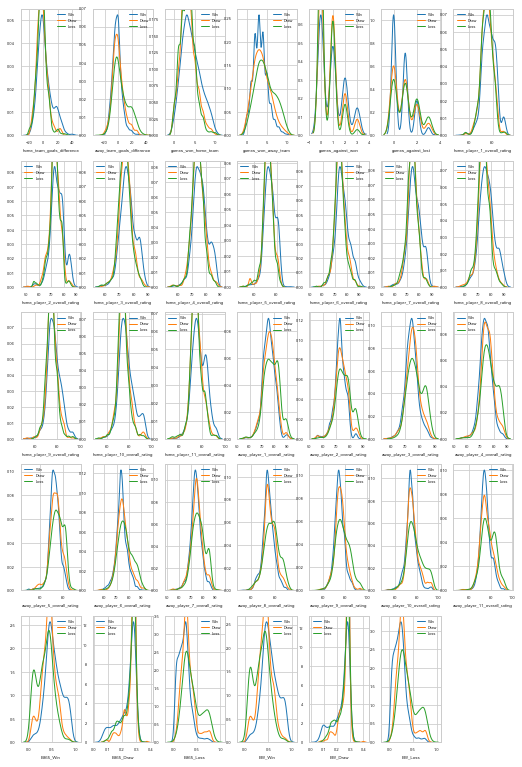

Win     0.484848
Loss    0.281227
Draw    0.233925
Name: label, dtype: float64


In [60]:
# Generating features, exploring the data, and preparing data for model training

# Add Fifa stats for players in the match
fifa_data = get_fifa_data(match_data, player_stats_data, data_exists = False)

# Creating features and labels based on data provided
bet_cols = ['B365', 'BW', 'IW', 'LB', 'PS', 'WH', 'SJ', 'VC', 'GB', 'BS']
bet_cols_selected = ['B365', 'BW']      
feables = create_features_and_labels(match_data, fifa_data, bet_cols_selected, get_overall = True)
inputs = feables.drop('match_api_id', axis = 1)

# Exploring the data and creating visualizations
labels = inputs.loc[:,'label']
features = inputs.drop('label', axis = 1)
features.head(5)
feature_details = explore_data(features, inputs, path)

In [80]:
from sklearn.model_selection import train_test_split
from sklearn import model_selection

# Splitting the data into Train, Calibrate, and Test data sets
X_train_calibrate, X_test, y_train_calibrate, y_test = train_test_split(features, labels, test_size = 0.2, random_state = 42, 
                                                                        stratify = labels)
X_train, X_calibrate, y_train, y_calibrate = train_test_split(X_train_calibrate, y_train_calibrate, test_size = 0.3, random_state = 42, 
                                                              stratify = y_train_calibrate)

#Creating cross validation data splits
cv_sets = model_selection.StratifiedShuffleSplit(n_splits = 5, test_size = 0.20, random_state = 5)
cv_sets.get_n_splits(X_train, y_train)

5

In [85]:
from sklearn.naive_bayes import GaussianNB
from sklearn import linear_model
from sklearn.metrics import classification_report, accuracy_score


# Train the model and print accuracy
clf = linear_model.LogisticRegression(multi_class = "ovr", solver = "sag", class_weight = 'balanced')
clf.fit(X_train, y_train)
print("Score of {} for training set: {:.4f}.".format(clf.__class__.__name__, accuracy_score(y_train, clf.predict(X_train))))
print("Score of {} for test set: {:.4f}.".format(clf.__class__.__name__, accuracy_score(y_test, clf.predict(X_test))))

# Train the model and print accuracy
clf = GaussianNB()
clf.fit(X_train, y_train)
print("Score of {} for training set: {:.4f}.".format(clf.__class__.__name__, accuracy_score(y_train, clf.predict(X_train))))
print("Score of {} for test set: {:.4f}.".format(clf.__class__.__name__, accuracy_score(y_test, clf.predict(X_test))))

Score of LogisticRegression for training set: 0.5211.
Score of LogisticRegression for test set: 0.5148.
Score of GaussianNB for training set: 0.4927.
Score of GaussianNB for test set: 0.5000.


/Users/paulsmsm/miniconda2/envs/ipykernel_py3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
